# OpenCSR tests



In [1]:
import numpy as np

import subprocess
import tempfile
import os
import glob
import time

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_format = 'retina'

In [2]:
# Executable 
TEST_BIN = os.path.abspath('../build/csr3d-test')
assert os.path.exists(TEST_BIN)

In [3]:
def parse_plane(file):
    rdat = np.loadtxt(file)
    shape = int(rdat[0]), int(rdat[1])
    print(shape)
    return rdat[2:].reshape(shape)

In [4]:
# Change any of this to test

PARAMS = """
&CSR3D_TEST_PARAMS
 SIZES=  64 32 128
 GAMMA=  500
 RHO=   1
 SIGMAS= 10e-6 10e-6 10e-6
 GAUSS_CUTOFF=  4
 Normalize = T
 /

"""

with open('test.in', 'w') as f:
    f.write(PARAMS)

In [5]:
!{TEST_BIN} test.in

 ------------------------
&CSR3D_TEST_PARAMS
 SIZES=64         ,32         ,128        ,
 GAMMA=  500.00000000000000     ,
 RHO=  1.0000000000000000     ,
 SIGMAS= 3*1.0000000000000001E-005  ,
 GAUSS_CUTOFF=  4.0000000000000000     ,
 CENTER= 3*0.0000000000000000       ,
 NORMALIZE=T,
 /
 ------------------------
 Gaussian mesh
 ------------------------
 Mesh: 
 size:           64          32         128
 min:   -4.0000000000000003E-005  -4.0000000000000003E-005  -4.0000000000000003E-005
 max:    4.0000000000000003E-005   4.0000000000000003E-005   4.0000000000000003E-005
 delta:    1.2698412698412699E-006   2.5806451612903228E-006   6.2992125984251978E-007
 gamma:    500.00000000000000     
 charge:    0.0000000000000000     
 density allocated
 wake allocated
 ------------------------
 ------------------------
 csr3d_steady_state
 csr3d_steady_state
 calc_density_derivative...
 calc_density_derivative...Done
OpenMP Green function calc get_cgrn_csr3d, n_threads = 8
 Multiply FFT'd arra

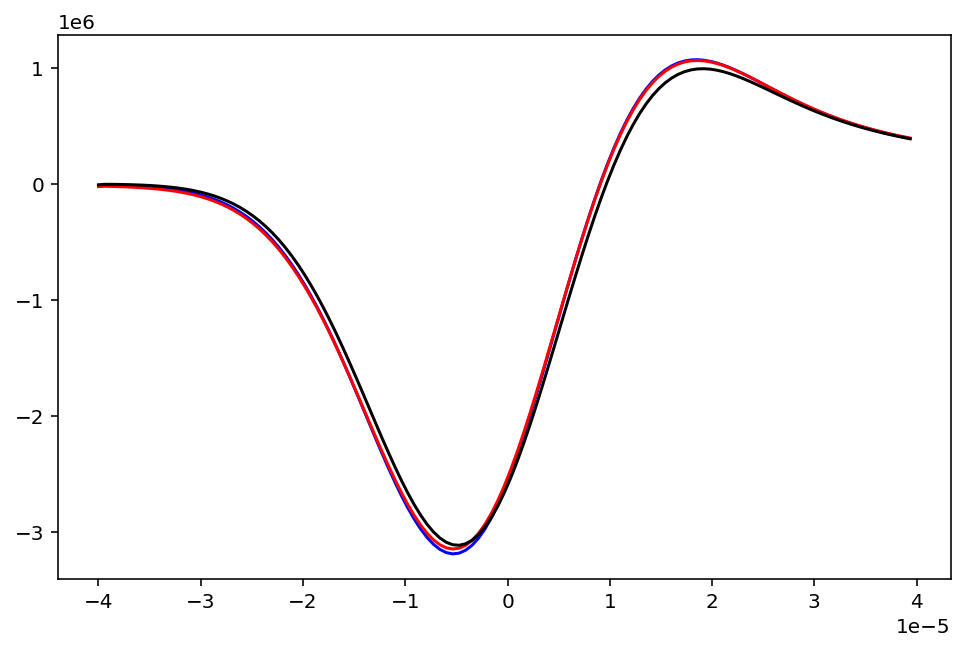

In [6]:
# Simple parser
def parse_line(file):
    rdat = np.loadtxt(file)
    columns = ['x', 'y', 'z', 'Wx', 'Wy', 'Ws']
    return {name:rdat[:,i] for i, name in enumerate(columns)}

fig, ax = plt.subplots(figsize=(8,5))

dat = parse_line('z_line.dat')
ax.plot(dat['z'], dat['Ws'], color='blue')

dat = parse_line('z_line_-sigma_x.dat')
ax.plot(dat['z'], dat['Ws'], color='red')

dat = parse_line('z_line_+sigma_x.dat')
ax.plot(dat['z'], dat['Ws'], color='black')

#dat = parse_lineout('x_lineout.dat')
#plt.plot(dat['x'], dat['Ex'])

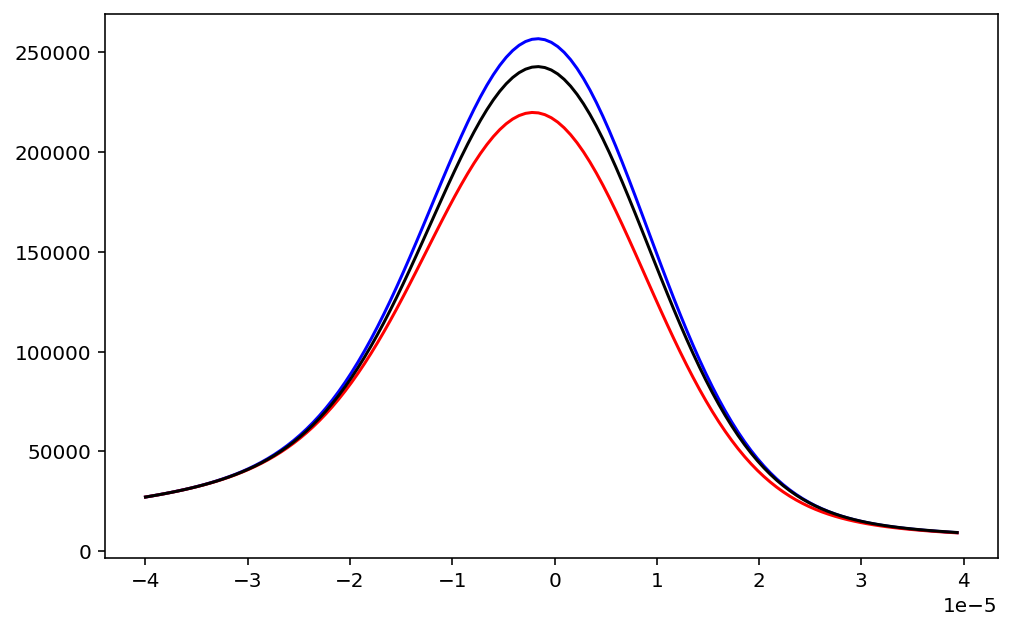

In [7]:
fig, ax = plt.subplots(figsize=(8,5))

dat = parse_line('z_line.dat')
ax.plot(dat['z'], dat['Wx'], color='blue')

dat = parse_line('z_line_-sigma_x.dat')
ax.plot(dat['z'], dat['Wx'], color='red')

dat = parse_line('z_line_+sigma_x.dat')
ax.plot(dat['z'], dat['Wx'], color='black')

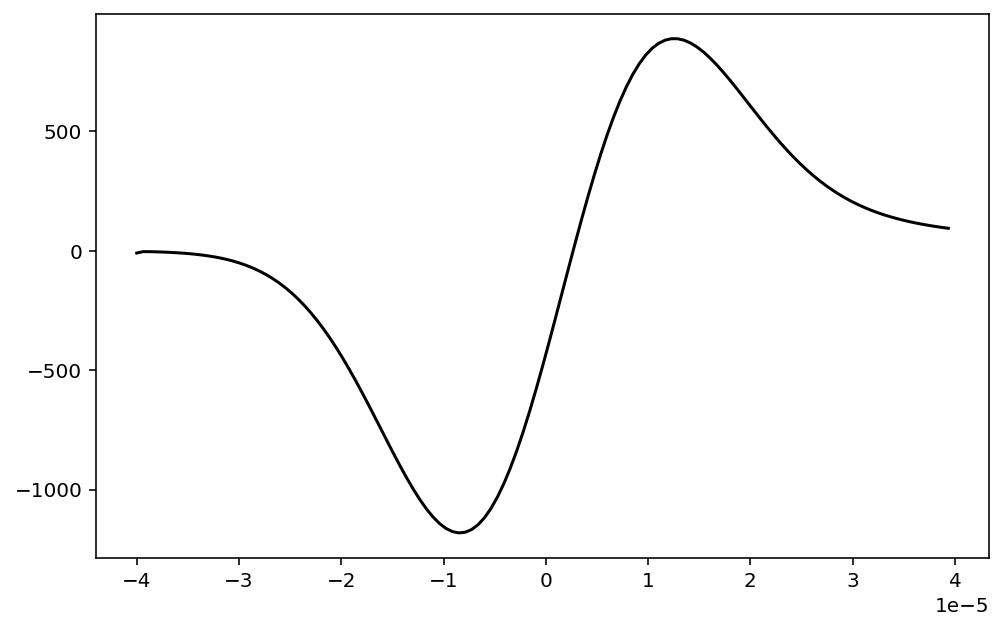

In [8]:

fig, ax = plt.subplots(figsize=(8,5))

dat = parse_line('z_line_+sigma_y.dat')
ax.plot(dat['z'], dat['Wy'], color='black')

# Parsers

Simple parsers for the line output and grid output text files

In [9]:
#plt.imshow(parse_2d('density_prime'))
#PSI = parse_2d('psi')
#plt.imshow(PSI)
#PSI.ptp()

In [10]:
# Simple parser
def parse_plane(file):
    """
    
    
    """
    rdat = np.loadtxt(file, skiprows = 1)
    columns = ['x', 'z', 'Wx', 'Wy', 'Ws', 'density']
    pdat =  {name:rdat[:,i] for i, name in enumerate(columns)}
    
    zvec = sorted(list(set(pdat['z'])))
    xvec = sorted(list(set(pdat['x'])))    
    nx, nz = len(xvec), len(zvec)
    dat = {}
    dat['zvec'] = np.array(zvec)
    dat['xvec'] = np.array(zvec)   
    for k in [ 'Wx', 'Wy', 'Ws', 'density']:
        dat[k] = pdat[k].reshape(nz, nx).T

    return dat
    

daty = parse_plane('xz_plane_+sigma_y.dat')
dat = parse_plane('xz_plane.dat')

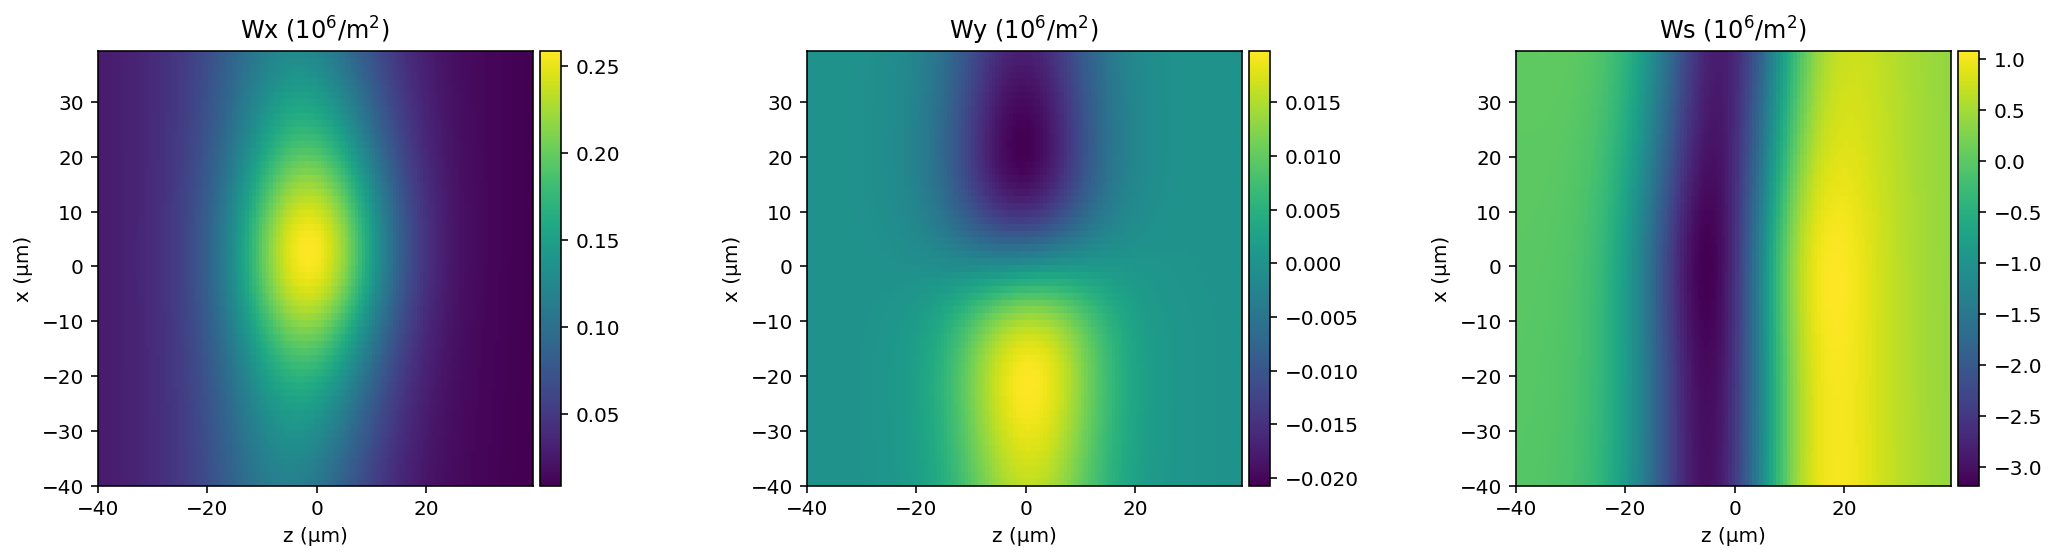

In [11]:
def plot_plane(dat):
    zmin, zmax, xmin, xmax = dat['zvec'].min(), dat['zvec'].max(), dat['xvec'].min(), dat['xvec'].max()
    
    fig, axes = plt.subplots(1,3, figsize=(18,4))
    
    for ax, name, unit in zip(axes, ['Wx', 'Wy', 'Ws'], 3*[r'$10^6$/m$^2$']):
        if name == 'Wy':
            W = daty[name]/1e6
        else:
            W = dat[name]/1e6
            
        
        im = ax.imshow(W, origin='lower', extent=[xmin/1e-6, xmax/1e-6, zmin/1e-6, zmax/1e-6])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        ax.set_title(f'{name} ({unit})')
        ax.set_xlabel('z (µm)')
        ax.set_ylabel('x (µm)')        
plot_plane(dat)

# Automate


In [12]:
def set_params(filename='params.in', sizes=(32,32,32), sigmas=(10e-6, 10e-6, 10e-6)):
    params = f"""
&CSR3D_TEST_PARAMS
 SIZES=  {sizes[0]} {sizes[1]} {sizes[2]} 
 GAMMA=  500
 RHO=  1
 SIGMAS= {sigmas[0]} {sigmas[1]} {sigmas[2]} 
 GAUSS_CUTOFF=  5
 /
    
    """
    with open(filename, 'w') as f:
        f.write(params)
set_params()        

In [13]:
def run_test(verbose=False, **params):
    dat = {}
    tdir = tempfile.TemporaryDirectory()
    fname = os.path.join(tdir.name, 'params.in')
    set_params(filename=fname, **params)
    t0 = time.time()
    res = subprocess.run([TEST_BIN, 'params.in'], cwd=tdir.name, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    dat['run_time'] = time.time() - t0
    if verbose:
        print(res.stdout.decode('utf-8'))

    for file in glob.glob(tdir.name+'/*dat'):
        _, name = os.path.split(file)
        if verbose:
            print('Parsing', name)
        if 'line' in name:
            dat[name] = parse_line(file)
        elif 'plane' in name:
            dat[name] = parse_plane(file)

    #dat['x_line'] = parse_lineout(os.path.join(tdir.name, 'x_lineout.dat'))
    #dat['z_line'] = parse_lineout(os.path.join(tdir.name, 'z_lineout.dat'))
    #dat['xz_plane'] = parse_plane(os.path.join(tdir.name, 'x_z_Ex_Ez_By.dat'))
#
    return dat

DAT = run_test(verbose=True)  
#plot_plane(DAT['xz_plane'])

 ------------------------
&CSR3D_TEST_PARAMS
 SIZES= 3*32         ,
 GAMMA=  500.00000000000000     ,
 RHO=  1.0000000000000000     ,
 SIGMAS= 3*1.0000000000000001E-005  ,
 GAUSS_CUTOFF=  5.0000000000000000     ,
 CENTER= 3*0.0000000000000000       ,
 NORMALIZE=T,
 /
 ------------------------
 Gaussian mesh
 ------------------------
 Mesh: 
 size:           32          32          32
 min:   -5.0000000000000002E-005  -5.0000000000000002E-005  -5.0000000000000002E-005
 max:    5.0000000000000002E-005   5.0000000000000002E-005   5.0000000000000002E-005
 delta:    3.2258064516129032E-006   3.2258064516129032E-006   3.2258064516129032E-006
 gamma:    500.00000000000000     
 charge:    0.0000000000000000     
 density allocated
 wake allocated
 ------------------------
 ------------------------
 csr3d_steady_state
 csr3d_steady_state
 calc_density_derivative...
 calc_density_derivative...Done
OpenMP Green function calc get_cgrn_csr3d, n_threads = 8
 Multiply FFT'd arrays, re-use cgrn
OpenM

# Timing and scaling

In [14]:
run_test(sizes=(32,32,32))['run_time']

0.18772292137145996

In [15]:
sizes0=np.array([32,32,32])
ALLDAT = {}

for n in range(1,10):
    
    ss = sizes0*n
    ALLDAT[n] = run_test(sizes=ss)
    rtime = ALLDAT[n]['run_time']
    print(ss, rtime )

[32 32 32] 0.18421578407287598
[64 64 64] 1.3411211967468262
[96 96 96] 4.599256277084351
[128 128 128] 11.347155094146729
[160 160 160] 19.924232006072998
[192 192 192] 45.634974002838135
[224 224 224] 61.594253063201904
[256 256 256] 131.73680996894836
[288 288 288] 126.58927798271179


Text(0.5, 0, 'gridpoints')

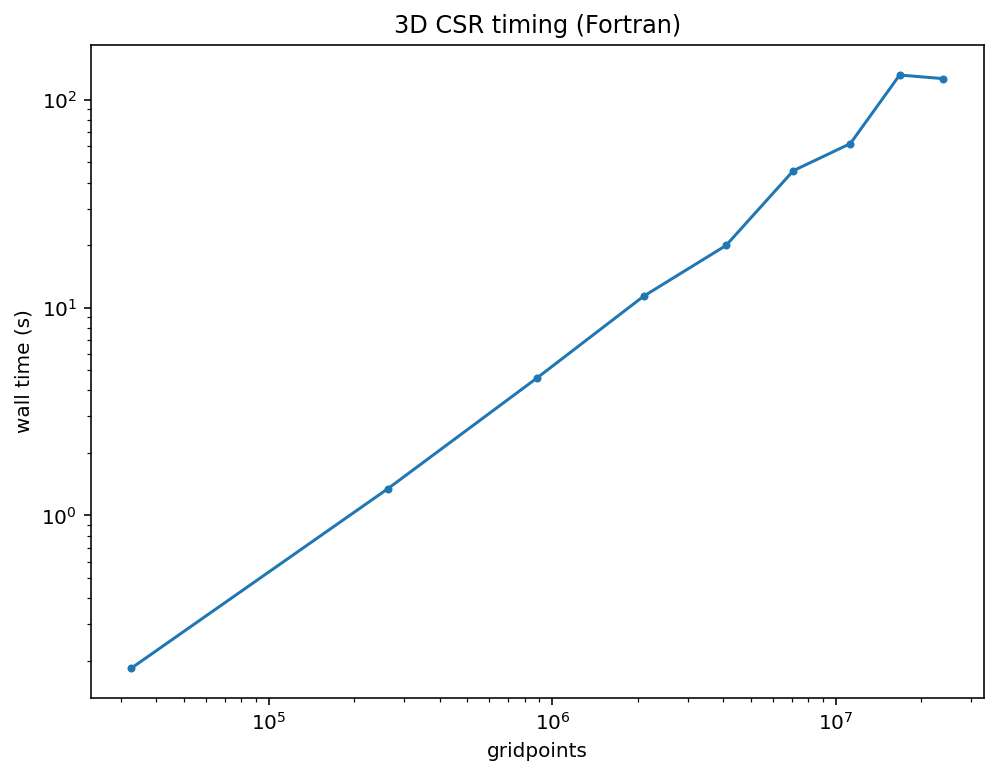

In [16]:

X = [ (n*sizes0[0])**3 for n in ALLDAT]
Y =[ALLDAT[n]['run_time'] for n in ALLDAT]
plt.xscale('log')
plt.yscale('log')
plt.plot(X, Y, marker='.')

plt.title('3D CSR timing (Fortran)')
plt.ylabel('wall time (s)')
plt.xlabel('gridpoints')

# 3D plots

In [17]:
# Get some data

DAT = ALLDAT[3]

pdat =DAT['xz_plane_+sigma_y.dat']


#pdat =DAT['xz_plane.dat']
#pdat = ALLDAT[8]['xz_plane.dat']
#plt.imshow(pdat['Wy'])

In [18]:
nicefield = {
    'Wx':r'$W_x$',
    'Wy':r'$W_y$',
    'Ws':r'$W_s$'
    
}

In [19]:
from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')

In [20]:
field = 'Wy'

xvec, zvec = pdat['xvec'], pdat['zvec']


X, Z= np.meshgrid(xvec, zvec, indexing="ij")
W = pdat[field]/1e6

#cdata = density.sum(axis=1)
cdata = pdat['density']
cdata = cdata/cdata.sum()

W.shape, Z.shape, X.shape, cdata.shape, W.min()

((95, 95), (95, 95), (95, 95), (95, 95), -0.02076354981226702)

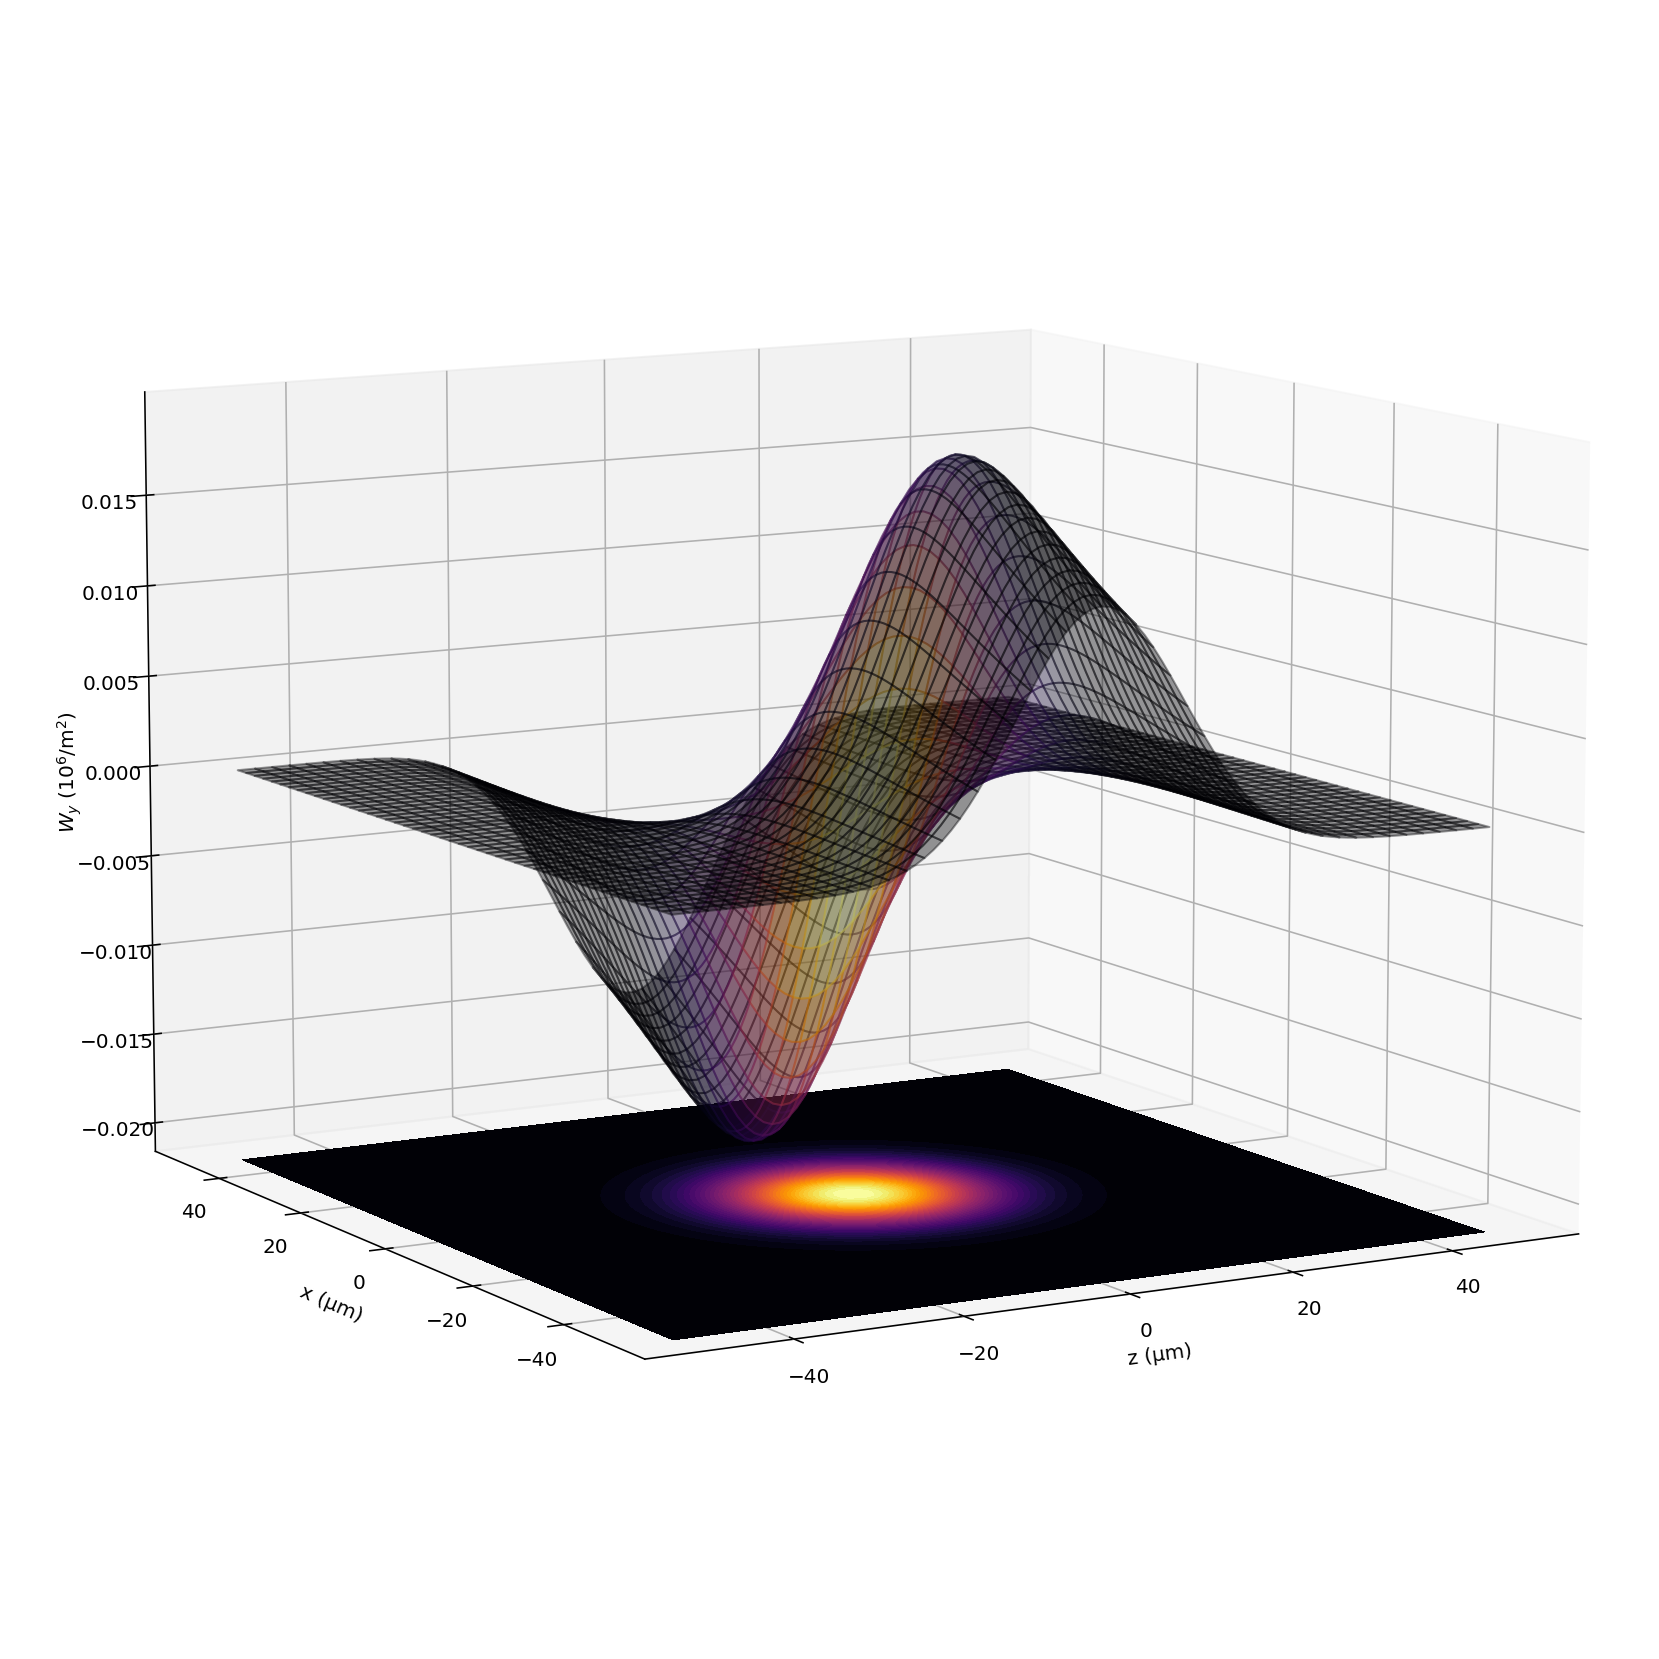

In [21]:
colors = cmap(cdata/cdata.max())

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z*1e6, X*1e6, W, alpha=0.4, facecolors=colors)

extent = np.array([zvec.min(), zvec.max(), xvec.min(), xvec.max()])*1e6

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)

ax.contourf(Z*1e6, X*1e6, cdata, 50, zdir='z', offset=W.min()*1.05, extent=extent, cmap=cmap)
#ax.set_title('3D CSR vertical wake')
ax.set_xlabel('z (µm)')
ax.set_ylabel('x (µm)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(nicefield[field] + ' '+r'($10^6$/m$^2$) ', rotation=90)
ax.view_init(10, 240)
#plt.savefig(f'{KEY}_3d.png', dpi=150)

In [22]:
def plot_field_3d(field, pdat, title='3D CSR wake'):
    xvec, zvec = pdat['xvec'], pdat['zvec']


    X, Z= np.meshgrid(xvec, zvec, indexing="ij")
    W = pdat[field]/1e6
    
    #cdata = density.sum(axis=1)
    cdata = pdat['density']
    cdata = cdata/cdata.sum()
    colors = cmap(cdata/cdata.max())
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Z*1e6, X*1e6, W, alpha=0.4, facecolors=colors)
    
    extent = np.array([zvec.min(), zvec.max(), xvec.min(), xvec.max()])*1e6
    
    #ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
    
    ax.contourf(Z*1e6, X*1e6, cdata, 50, zdir='z', offset=W.min()*1.05, extent=extent, cmap=cmap)
    #ax.set_title(title)
    ax.set_xlabel('z (µm)')
    ax.set_ylabel('x (µm)')
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(nicefield[field] + ' '+r'($10^6$/m$^2$) ', rotation=90)
    ax.view_init(10, 240)
    #plt.savefig(f'{KEY}_3d.png', dpi=150)
    fig.tight_layout()

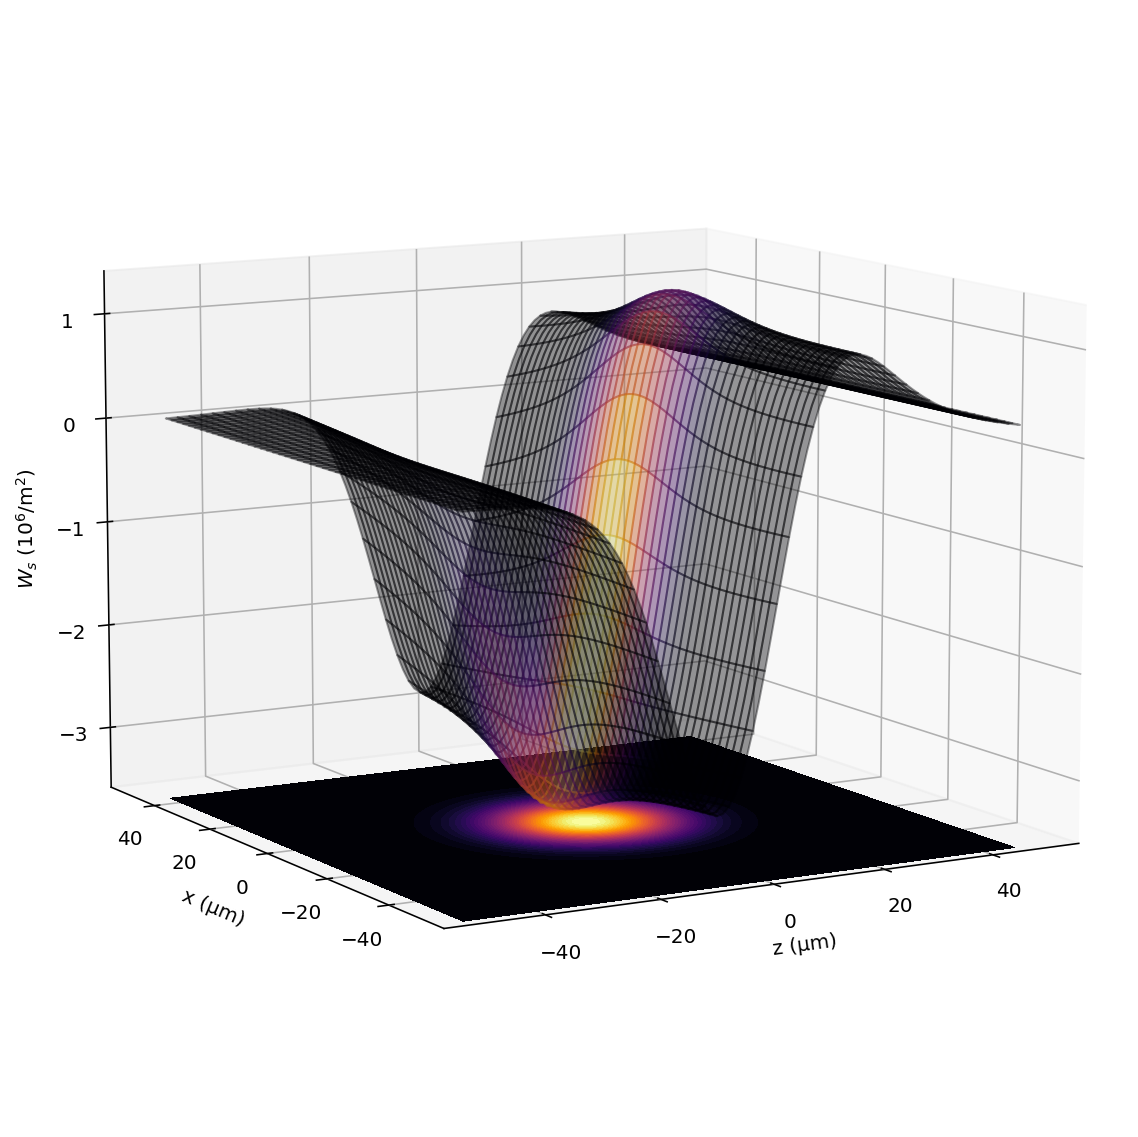

In [23]:
pdat = DAT['xz_plane.dat']
plot_field_3d('Ws', pdat)
PFILE = '../img/Ws_3d.png'
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

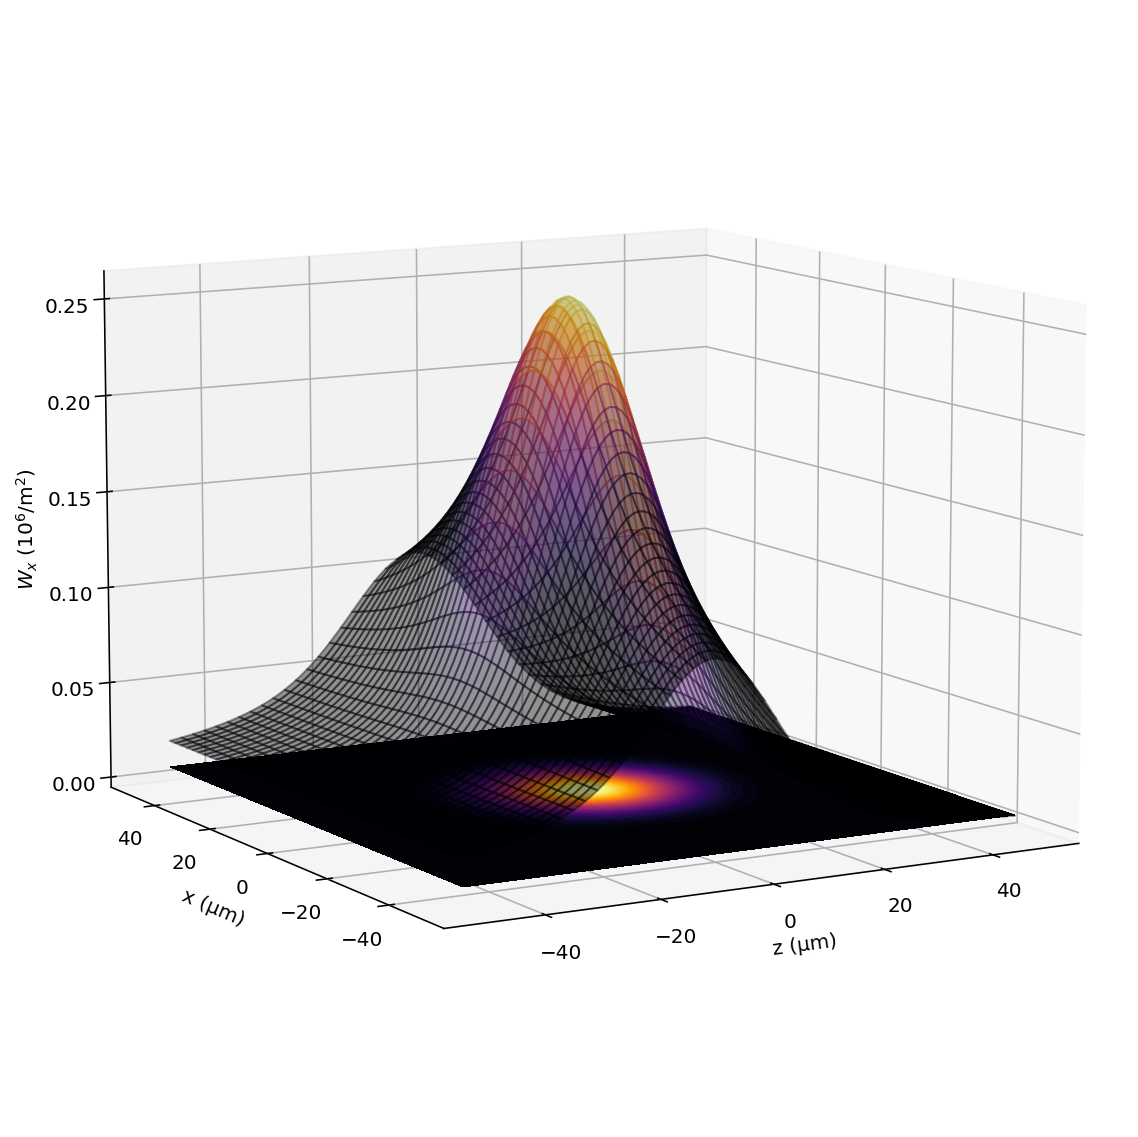

In [24]:
pdat = DAT['xz_plane.dat']
plot_field_3d('Wx', pdat)
PFILE = '../img/Wx_3d.png'
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

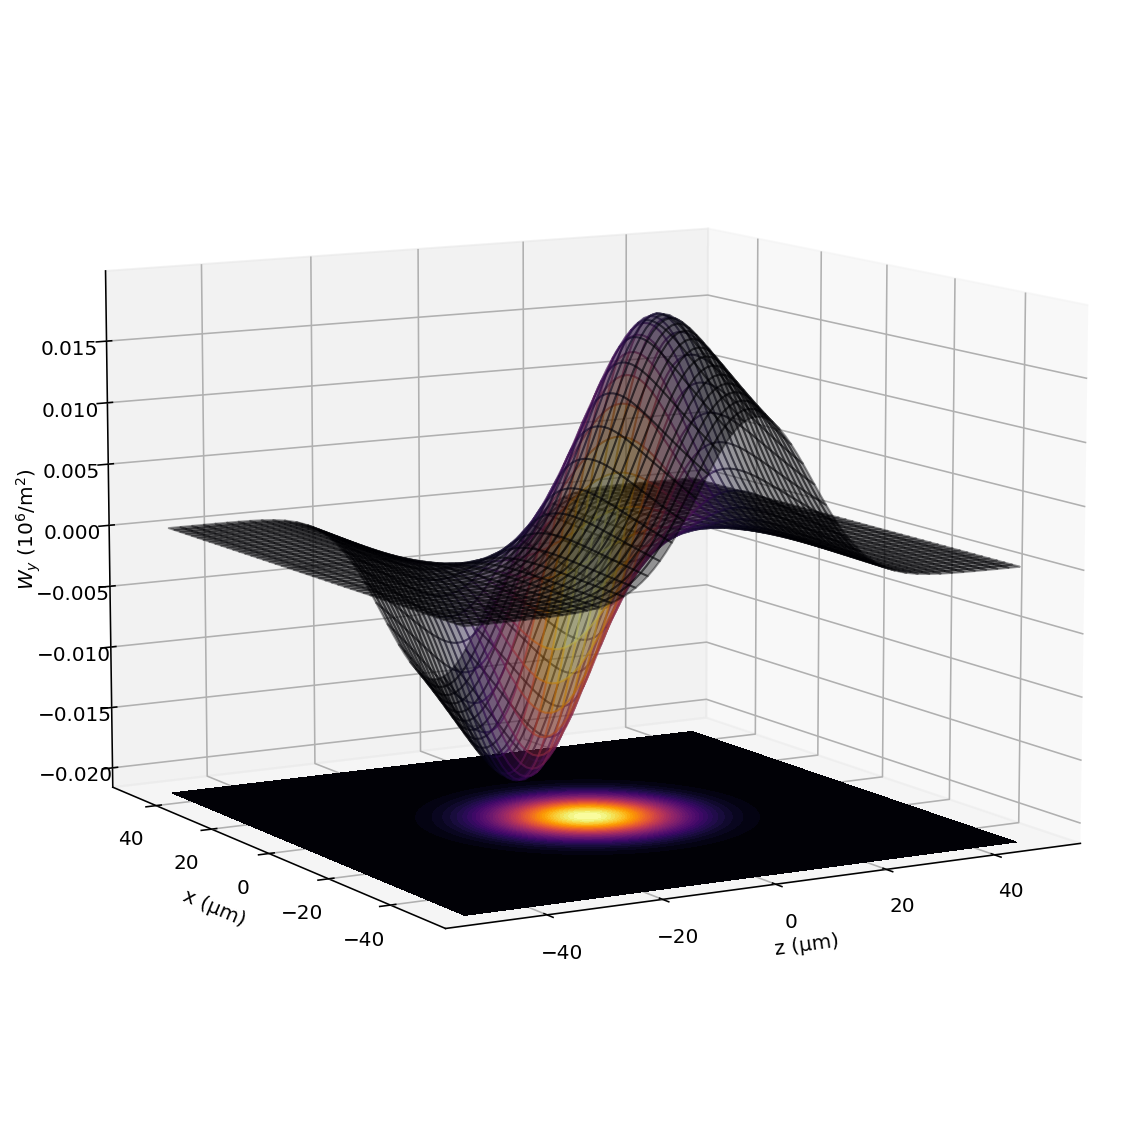

In [25]:
pdat = DAT['xz_plane_+sigma_y.dat']
plot_field_3d('Wy', pdat, '3D CSR vertical wake at '+r'$+\sigma_y$')
PFILE = '../img/Wy_3d.png'
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

# Cleanup

In [26]:
# Cleanup
!rm *in
!rm *dat